In [ ]:
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt

In [1]:
from tensorflow.keras.models import Sequential, Model #for modeling
from tensorflow.keras.layers import Dense, Embedding, LSTM, Input, SpatialDropout1D, Conv1D,MaxPool1D,BatchNormalization, GRU, SimpleRNN, Dropout,Flatten, concatenate,Bidirectional, GlobalMaxPool1D #CNN and LSTM layers
from tensorflow.keras import utils 
from tensorflow.keras.optimizers import Adam, RMSprop, Adadelta
from tensorflow.keras import callbacks
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.preprocessing.sequence import pad_sequences 
from tensorflow.keras import regularizers

from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.initializers import Constant

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer # for tfid

from scipy.sparse import hstack

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.corpus import brown
from nltk.stem.snowball import SnowballStemmer # for data cleaning

import random
import time
from textblob import TextBlob

In [2]:
#train = pd.read_csv('train.csv').fillna(' ') #tuve que poner fillna para el tfidf
#test =  pd.read_csv('test.csv').fillna(' ')
train = pd.read_csv('train.csv')
test =  pd.read_csv('test.csv')

In [3]:
#Data cleaning

In [4]:
#nltk.download('wordnet')
stop_words = set(stopwords.words("english")) 
lemmatizer = WordNetLemmatizer()

In [5]:
def clean_text(text):
    text = re.sub(r'[^\w\s]','',text, re.UNICODE)
    text = text.lower()
    text = [lemmatizer.lemmatize(token) for token in text.split(" ")]
    text = [lemmatizer.lemmatize(token, "v") for token in text]
    text = [word for word in text if not word in stop_words]
    text = " ".join(text)
    return text

#removing any shortforms if present
def remove_shortforms(phrase):
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

def remove_special_char(text):
    text = re.sub('[^A-Za-z0-9]+'," ",text)
    return text

def remove_wordswithnum(text):
    text = re.sub("\S*\d\S*", "", text).strip()
    return text

def lowercase(text):
    text = text.lower()
    return text

st = SnowballStemmer(language='english')
def stemming(text):
    r= []
    for word in text :
        a = st.stem(word)
        r.append(a)
    return r

def remove_punctuations(text):
    text = re.sub(r'[^\w\s]','',text)
    return text

def remove_links(text):
    text = re.sub(r'http\S+', '', text)
    return text

lemmatizer = WordNetLemmatizer()
def lemmatize_words(text):
    text = lemmatizer.lemmatize(text)
    return text

def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

In [6]:
for i in range(len(train['text'])):
    train['text'][i] = str(train['text'][i])

/home/matias/anaconda3/envs/nlp/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [7]:
"""for i in range(len(train['text'])):
    #train['text'][i] = remove_shortforms(train['text'][i])
    #train['text'][i] = remove_special_char(train['text'][i])
    #train['text'][i] = remove_wordswithnum(train['text'][i])
    train['text'][i] = lowercase(train['text'][i])
    train['text'][i] = remove_links(train['text'][i])
    train['text'][i] = clean_text(train['text'][i])
    #text = train['text'][i]
    #text = text.split()
    #train['text'][i] = stemming(text)
    #s = train['text'][i]
    #train['text'][i] = lemmatize_words(train['text'][i])"""

"for i in range(len(train['text'])):\n    #train['text'][i] = remove_shortforms(train['text'][i])\n    #train['text'][i] = remove_special_char(train['text'][i])\n    #train['text'][i] = remove_wordswithnum(train['text'][i])\n    train['text'][i] = lowercase(train['text'][i])\n    train['text'][i] = remove_links(train['text'][i])\n    train['text'][i] = clean_text(train['text'][i])\n    #text = train['text'][i]\n    #text = text.split()\n    #train['text'][i] = stemming(text)\n    #s = train['text'][i]\n    #train['text'][i] = lemmatize_words(train['text'][i])"

## Pro processor
source: https://www.kaggle.com/gunesevitan/nlp-with-disaster-tweets-eda-cleaning-and-bert

In [8]:
all_text = pd.concat([train['text'], test['text']])

In [9]:
custom_stop_list = []
#stop_files=['slang.txt']
#for stopfile in stop_files:
#    with open("../data/"+stopfile) as f:
#        for line in f:
#            custom_stop_list.extend(line.split())

stopword_set = stopwords.words('english')+custom_stop_list+['url']

# Reference : https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b
#https://www.kaggle.com/shahules/basic-eda-cleaning-and-glove

def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

remove_emoji("Omg another Earthquake 😔😔")
def preProcess(iter):
    #https://www.kaggle.com/shahules/basic-eda-cleaning-and-glove         
        
        # remove extra space
        regex_ws=re.compile("\s+")
        ret=regex_ws.sub(" ",iter)
        
        ret=ret.replace("&amp;","&").replace("&lt;","<").replace("&gt;",">")
        
        #Replace slang words
        #for key in abbreviations.keys():
        #    ret=ret.replace(key,abbreviations[key])
        
        #Replace URL
        regexp="(https?:\/\/(?:www\.|(?!www)|(?:xmlns\.))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})"
        ret=re.sub(regexp,"url",ret)
        
        #replace @addresses
        regexp='@[A-z0-9_]+'
        ret=re.sub(regexp,"@twitterhandle",ret)
        
        ret=remove_emoji(ret)
        #ret=replace_contractions(ret)
        #Split on punctuations
        ret1=re.split("[,_, \<>!\?\.:\n\"=*/]+",ret)
        
        #Remove Stopwords
        ret2=[word for word in ret1 if word not in stopword_set]
        ret2=" ".join(ret2)
        
        #Remove  numbers
        ret2=re.sub(r"(\s\d+)"," ",ret2)
                
        #STEM TEXT
        #ret3=stem_text(strip_punctuation(ret2))
    
        return ret2
te=preProcess("I'll make the day a fantastic 1!!")
print(te)

I'll make day fantastic  


## Embedding

In [10]:
maxWordsCount = 20000
tokenizer = Tokenizer(num_words=maxWordsCount, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True, split=' ', oov_token='unknown', char_level=False)
tokenizer.fit_on_texts(train['text'])
word_index = tokenizer.word_index
vocab_size = max_features = len(word_index)

In [11]:
trainWordIndexes = tokenizer.texts_to_sequences(train['text']) 

In [12]:
path_file = '/home/matias/workspace-ia/Organización de Datos - UBA/tp-2/tutorial/cnn/glove.6B.100d.txt'
embedding_dict_100d={}
with open(path_file,'r', encoding='utf8') as f:
    for line in f:
        values=line.split(' ')
        word=values[0]
        vectors=np.asarray(values[1:],'float32')
        embedding_dict_100d[word]=vectors
f.close()

print('The size of the embedding index is : %d'%(len(embedding_dict_100d)))

The size of the embedding index is : 400000


In [13]:
embedding_dim  = 100

embedding_matrix = np.zeros((max_features+1, embedding_dim))

for word, i in word_index.items():
  if i < max_features:
    
    try:
      embedding_matrix[i] =embedding_dict_100d[word]
    except KeyError:  
      embedding_matrix[i] = np.zeros((1, embedding_dim))
embedding_matrix.shape

(22701, 100)

In [14]:
maxLen = 25
XEmb = pad_sequences(trainWordIndexes, maxlen=maxLen,padding='post')
y = np.asarray(train['target'])
#y = np.asarray(train_target)

In [15]:
xTrain, xVal, yTrain, yVal = train_test_split(XEmb, y, test_size=0.20)

In [16]:
checkpoint = ModelCheckpoint("/home/matias/workspace-ia/Organización de Datos - UBA/tp-2/nlp_dissaster_tweet/Emb-cnn-lstm/checkpoint_emb_cnn_lstm_keywords.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 10,
                          verbose = 1,
                          restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.2,
                              patience = 7,
                              verbose = 1,
                              min_delta = 0.0001)

# we put our call backs into a callback list
#callbacks_m = [checkpoint, reduce_lr]
callbacks_m = [checkpoint, earlystop, reduce_lr]

In [17]:
#Embedding
model = Sequential()
model.add(Embedding(max_features+1, embedding_dim, mask_zero=True,embeddings_initializer=Constant(embedding_matrix)))
model.add(SpatialDropout1D(0.5))
#CNN
model.add(Conv1D(filters=32,kernel_size=8, activation='relu', padding="valid", strides = 1))
model.add(MaxPool1D(pool_size=4))
#LSTM
model.add(Bidirectional(LSTM(32, return_sequences = True, dropout=0.3, recurrent_dropout=0.5)))
model.add(GlobalMaxPool1D())
model.add(Dropout(0.5))
model.add(Dense(1, activation="sigmoid"))
#Compile
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         2270100   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, None, 100)         0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 32)          25632     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 32)          0         
_________________________________________________________________
bidirectional (Bidirectional (None, None, 64)          16640     
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
dropout (Dropout)            (None, 64)                0

In [18]:
#xTrain, xVal, yTrain, yVal = train_test_split(XEmb, y, test_size=0.20)
history = model.fit(xTrain,yTrain,epochs=10,batch_size=32, validation_data=(xVal, yVal), callbacks=[callbacks_m])

Epoch 1/10
191/191 [==============================] - ETA: 0s - loss: 0.5931 - accuracy: 0.6915
Epoch 00001: val_loss improved from inf to 0.46368, saving model to /home/matias/workspace-ia/Organización de Datos - UBA/tp-2/nlp_dissaster_tweet/Emb-cnn-lstm/checkpoint_emb_cnn_lstm_keywords.h5
191/191 [==============================] - 10s 52ms/step - loss: 0.5931 - accuracy: 0.6915 - val_loss: 0.4637 - val_accuracy: 0.8011 - lr: 0.0010
Epoch 2/10
191/191 [==============================] - ETA: 0s - loss: 0.4952 - accuracy: 0.7750
Epoch 00002: val_loss improved from 0.46368 to 0.44540, saving model to /home/matias/workspace-ia/Organización de Datos - UBA/tp-2/nlp_dissaster_tweet/Emb-cnn-lstm/checkpoint_emb_cnn_lstm_keywords.h5
191/191 [==============================] - 8s 44ms/step - loss: 0.4952 - accuracy: 0.7750 - val_loss: 0.4454 - val_accuracy: 0.8056 - lr: 0.0010
Epoch 3/10
191/191 [==============================] - ETA: 0s - loss: 0.4562 - accuracy: 0.7969
Epoch 00003: val_loss imp

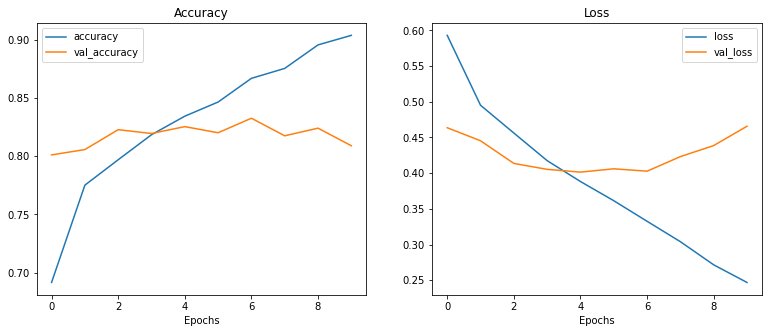

In [19]:
def plots_visual(result_model):
  fig, axes = plt.subplots(1, 2, figsize=(13,5))
  axes[0].plot(result_model.history['accuracy'])
  axes[0].plot(result_model.history['val_accuracy'])
  axes[0].legend(['accuracy', 'val_accuracy'])
  axes[0].set_title('Accuracy')
  axes[0].set_xlabel('Epochs')
  axes[1].plot(result_model.history['loss'])
  axes[1].plot(result_model.history['val_loss'])
  axes[1].legend(['loss', 'val_loss'])
  axes[1].set_title('Loss')
  axes[1].set_xlabel('Epochs')
plots_visual(history)

In [20]:
from tensorflow.keras.models import load_model
model  = load_model('/home/matias/workspace-ia/Organización de Datos - UBA/tp-2/nlp_dissaster_tweet/Emb-cnn-lstm/checkpoint_emb_cnn_lstm_keywords.h5')

In [21]:
def prediction(data, namefile):
    data = data.copy()
    data['text'] = data['text'].apply(clean_text)
    dataval = tokenizer.texts_to_sequences(data['text'])
    text_sequens = pad_sequences(dataval, maxlen=maxLen,padding='post')
    predictions = model.predict(text_sequens)
    predictions = np.round(predictions).astype(int).reshape(3263)
    testData = data[['id']]
    testData['target'] = predictions
    testData.to_csv(f'{namefile}.csv',index=False)

In [22]:
#prediction(test, 'submission')

## Keywords

In [23]:
train['keyword'].value_counts()

fatalities               45
armageddon               42
deluge                   42
sinking                  41
harm                     41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Length: 221, dtype: int64

In [24]:
train_df_copy = train
train_df_copy = train_df_copy.fillna('None')
ag = train_df_copy.groupby('keyword').agg({'text':np.size, 'target':np.mean}).rename(columns={'text':'Count', 'target':'Disaster Probability'})

ag.sort_values('Disaster Probability', ascending=False).head(20)

Count  Disaster Probability
keyword                                           
wreckage                  39              1.000000
debris                    37              1.000000
derailment                39              1.000000
outbreak                  40              0.975000
oil%20spill               38              0.973684
typhoon                   38              0.973684
suicide%20bombing         33              0.969697
suicide%20bomber          31              0.967742
bombing                   29              0.931034
suicide%20bomb            35              0.914286
rescuers                  35              0.914286
nuclear%20disaster        34              0.911765
evacuated                 36              0.888889
razed                     35              0.885714
wildfire                  33              0.878788
wild%20fires              31              0.870968
airplane%20accident       35              0.857143
buildings%20on%20fire     33              0.848485
mass%20murder             33              0.848485
forest%20fires            32              0.843750

In [25]:
count = 2
prob_disaster = 0.9
keyword_list_disaster = list(ag[(ag['Count']>count) & (ag['Disaster Probability']>=prob_disaster)].index)
#we print the list of keywords which will be used for prediction correction 
keyword_list_disaster

['bombing',
 'debris',
 'derailment',
 'nuclear%20disaster',
 'oil%20spill',
 'outbreak',
 'rescuers',
 'suicide%20bomb',
 'suicide%20bomber',
 'suicide%20bombing',
 'typhoon',
 'wreckage']

In [26]:
def prediction_keywords(data, namefile):
    data = data.copy()
    data['text'] = data['text'].apply(clean_text)
    dataval = tokenizer.texts_to_sequences(data['text'])
    text_sequens = pad_sequences(dataval, maxlen=maxLen,padding='post')
    predictions = model.predict(text_sequens)
    predictions = np.round(predictions).astype(int).reshape(3263)
    testData = data[['id']]
    testData['target'] = predictions
    ids_disaster = test['id'][test.keyword.isin(keyword_list_disaster)].values
    testData['target'][testData['id'].isin(ids_disaster)] = 1
    testData.to_csv(f'{namefile}.csv',index=False)

In [27]:
#ids_disaster = test['id'][test.keyword.isin(keyword_list_disaster)].values
#submission['target'][submission['id'].isin(ids_disaster)] = 1

In [28]:
prediction_keywords(test,'submission_keywords')

#submission.to_csv("submission.csv", index=False)
#submission.head(10)

/home/matias/anaconda3/envs/nlp/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/home/matias/anaconda3/envs/nlp/lib/python3.7/site-packages/pandas/core/generic.py:8765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
